In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tabla(N=1000):
    tc = np.random.uniform(0, 1, N)
    phi_c = np.random.uniform(0, 2 * np.pi, N)
    psi = np.random.uniform(0, 2 * np.pi, N)
    RA = np.random.uniform(0, 2 * np.pi, N)
    iota = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    DEC = np.arccos(1 - 2 * np.random.uniform(0, 1, N))

    tabla = pd.DataFrame({
        'tc': tc,
        'phi_c': phi_c,
        'psi': psi,
        'RA': RA,
        'iota': iota,
        'DEC': DEC
    })

    return tabla

parametros = generar_tabla(1000)
print(parametros.head())
parametros.to_csv("parametrosgeneradosN1000.csv", index=False)

         tc     phi_c       psi        RA      iota       DEC
0  0.451385  3.164969  3.364741  5.913891  1.965726  1.633465
1  0.842264  4.859336  2.745600  6.165741  1.158077  1.792019
2  0.412952  1.794751  1.714062  3.735868  0.212236  2.439888
3  0.826165  1.906946  2.352586  5.115857  0.597260  1.291617
4  0.491397  1.584446  1.776847  2.288493  2.471244  1.389224


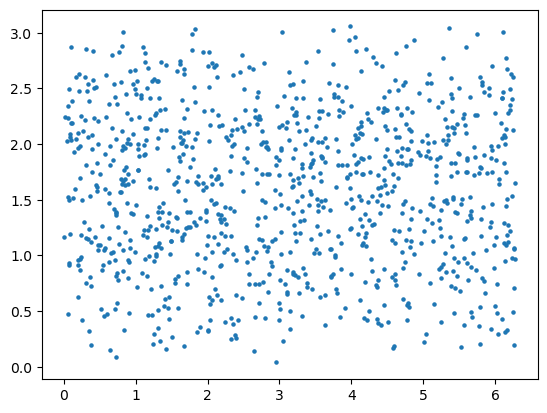

In [3]:
plt.scatter(parametros['RA'], parametros['DEC'], s=5)

C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\3873040114.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\3873040114.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])


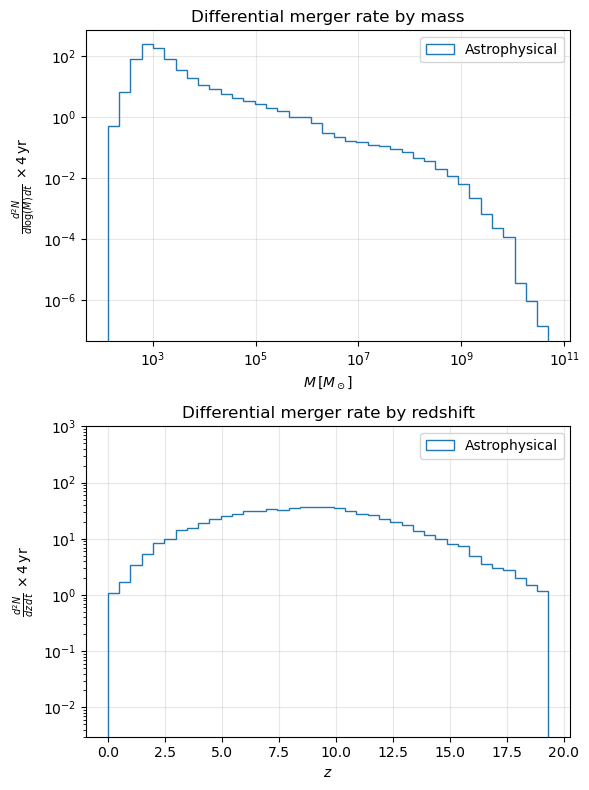

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII_K16.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 40)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.7 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\1331263930.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\1331263930.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])


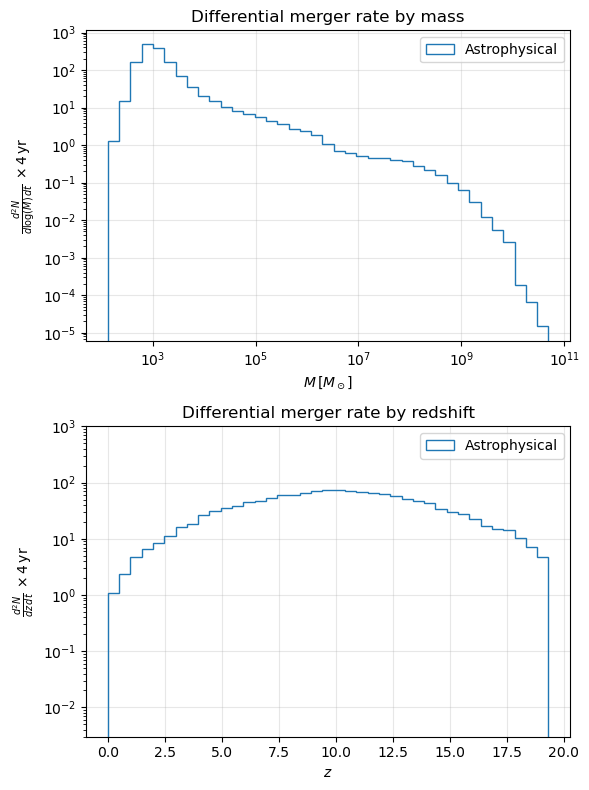

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII_K16_extrapolated.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 40)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.6 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
#axs[0].set_ylim(5e-2, 1400)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


In [78]:
total_events = np.sum(z_hist)
print(total_events * 3600* 24 * 365 * 4)

1403.9709471606616


In [84]:
print(data["d2N_dzdt"])

0         4.921604e-09
1         5.679258e-09
2         4.362020e-09
3         1.517043e-09
4         1.438444e-09
              ...     
727876    1.515308e-16
727877    5.969788e-17
727878    1.109368e-16
727879    7.508846e-18
727880    1.002663e-18
Name: d2N_dzdt, Length: 727881, dtype: float64


In [86]:
print(data["dN_dt"])

0         1.731519e-08
1         1.731519e-08
2         1.731519e-08
3         1.731519e-08
4         1.731519e-08
              ...     
727876    1.731519e-08
727877    1.731519e-08
727878    1.731519e-08
727879    1.731519e-08
727880    1.731519e-08
Name: dN_dt, Length: 727881, dtype: float64


In [104]:
print(1.731519e-08 * 3600* 24 * 365 * 4)

2.1842073273600002


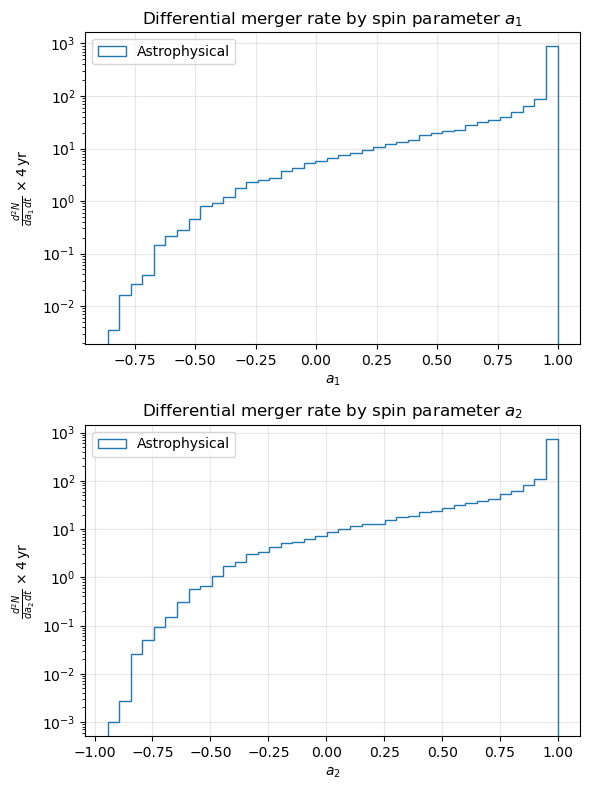

In [90]:
a1_bins = np.linspace(data["a1"].min(), data["a1"].max(), 40)
a1_hist, a1_edges = np.histogram(data["a1"], bins=a1_bins, weights=data["d2N_dzdt"])

a2_bins = np.linspace(data["a2"].min(), data["a2"].max(), 40)
a2_hist, a2_edges = np.histogram(data["a2"], bins=a2_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (a1_edges[:-1] + a1_edges[1:]), 
    bins=a1_bins,
    weights=a1_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
#axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$a_1$")
axs[0].set_ylabel(r"$\frac{d^2N}{da_1 \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title(r"Differential merger rate by spin parameter $a_1$")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (a2_edges[:-1] + a2_edges[1:]),  
    bins=a2_bins,
    weights=a2_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$a_2$")
axs[1].set_ylabel(r"$\frac{d^2N}{da_2 \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title(r"Differential merger rate by spin parameter $a_2$")
axs[1].grid(alpha=0.3)
#axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


In [92]:
import pandas as pd
import numpy as np

time_factor = 3600 * 24 * 365 

data["event_probability"] = data["d2N_dzdt"] * time_factor

probabilities = data["event_probability"] / data["event_probability"].sum()  # Normalizar las probabilidades

expected_events = int(data["event_probability"].sum())

print(f"Eventos esperados en 1 año: {expected_events}")

sampled_events = data.sample(n=expected_events, weights=probabilities, replace=True)
selected_columns = ["m1", "m2", "a1", "a2","DL", "z_merger", "alpha", "beta", "gamma"]
sampled_events = sampled_events[selected_columns]

sampled_events.to_csv("popIII_catalog.csv", index=False)

Eventos esperados en 1 año: 352


In [94]:
pd.read_csv('popIII_catalog.csv')

,m1,m2,a1,a2,DL,z_merger,alpha,beta,gamma
0,888.699,525.8100,0.944130,0.997525,129358.448416,11.92690,0.246637,0.093010,0.160917
1,749.342,503.2400,0.998000,0.998000,157926.376049,14.24900,0.223792,0.130081,0.104134
2,602.428,366.5810,0.998000,0.998000,149938.997594,13.60300,0.278755,0.146768,0.164108
3,355.482,313.4300,0.952579,0.909235,172924.409040,15.45610,0.109798,0.118474,0.155407
4,249.992,96.7754,0.466501,0.754191,102285.545965,9.69077,0.127314,0.058905,0.075757
...,...,...,...,...,...,...,...,...,...
347,1019.630,889.6580,0.997188,0.998000,121066.234824,11.24620,0.124592,0.049567,0.152267
348,1131.550,519.4240,0.998000,0.489503,121964.464344,11.32010,0.046250,0.124997,0.108808
349,828.005,379.1950,0.972530,0.998000,101817.711548,9.65175,0.043274,0.082092,0.115559
350,1932.670,404.7710,0.998000,0.863201,53891.826865,5.55268,0.190938,0.144966,0.087833


In [106]:
data["event_probability"].sum()

352.50771888876193

In [133]:
parametros = pd.read_csv("parametrosgeneradosN1000.csv")

n_eventos = len(sampled_events)

sampled_events_expanded = pd.DataFrame(np.repeat(sampled_events.values, 1000, axis=0), columns=sampled_events.columns)
parametros_expanded = pd.concat([parametros] * n_eventos, ignore_index=True)

if len(sampled_events_expanded) == len(parametros_expanded):
    final_catalog = pd.concat([sampled_events_expanded.reset_index(drop=True), parametros_expanded], axis=1)
    
    final_catalog.to_csv("popIII_catalogfinal.csv", index=False)
    print(" Catálogo final generado: popIII_catalogfinal.csv")
else:
    print(f" Error: Tamaños desiguales - Eventos: {len(sampled_events_expanded)}, Parámetros: {len(parametros_expanded)}")


 Catálogo final generado: popIII_catalogfinal.csv


In [134]:
pd.read_csv('popIII_catalogfinal.csv')

,m1,m2,a1,a2,DL,z_merger,alpha,beta,gamma,tc,phi_c,psi,RA,iota,DEC
0,888.699,525.810,0.94413,0.997525,129358.448416,11.92690,0.246637,0.093010,0.160917,0.451385,3.164969,3.364741,5.913891,1.965726,1.633465
1,888.699,525.810,0.94413,0.997525,129358.448416,11.92690,0.246637,0.093010,0.160917,0.842264,4.859336,2.745600,6.165741,1.158077,1.792019
2,888.699,525.810,0.94413,0.997525,129358.448416,11.92690,0.246637,0.093010,0.160917,0.412952,1.794751,1.714062,3.735868,0.212236,2.439888
3,888.699,525.810,0.94413,0.997525,129358.448416,11.92690,0.246637,0.093010,0.160917,0.826165,1.906946,2.352586,5.115857,0.597260,1.291617
4,888.699,525.810,0.94413,0.997525,129358.448416,11.92690,0.246637,0.093010,0.160917,0.491397,1.584446,1.776847,2.288493,2.471244,1.389224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351995,814.705,414.388,0.99715,0.998000,79095.514119,7.73696,0.088376,0.045019,0.074585,0.195034,0.410260,6.080358,1.823930,0.211334,2.091661
351996,814.705,414.388,0.99715,0.998000,79095.514119,7.73696,0.088376,0.045019,0.074585,0.708072,5.676637,1.905062,2.291263,1.204627,1.085216
351997,814.705,414.388,0.99715,0.998000,79095.514119,7.73696,0.088376,0.045019,0.074585,0.214742,2.122477,1.416614,2.925135,2.447991,0.391449
351998,814.705,414.388,0.99715,0.998000,79095.514119,7.73696,0.088376,0.045019,0.074585,0.741773,4.525031,1.966479,1.754633,0.346498,1.577570
